In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import Image
import warnings 
warnings.filterwarnings("ignore")

### Lecture 24:

- Find out about Machine Learning
- Learn about using the scikit-learn python package for machine learning.
- Apply machine learning to Earth Science problems

### What is machine learning anyway?

Machine Learning is one of those buzzwords you seem to hear all over the place these days, but what does it actually mean?

At it's simplest, machine learning is a way of finding 'features' in and assigning 'labels' to your data that allow you to build models.

There are two main types of machine learning, 'supervised' and 'unsupervised'. 

'Supervised' machine learning involves labeling a subset of your data and fitting a known type of model to explain these labels. The computer then applies this model to new data and can label the new data automatically. The labels you apply to data can be a continuous set of values, this is known as 'regression' or they can be discrete, this is known as 'classification'. 

We're all pretty familiar with supervised machine learning already. Every time you try to log into a website and you have to click on pictures of cars or road signs to log in, you're teaching Google how to recognise those objects in images. Google then uses those data to create models that it uses to teach its self driving cars how to 'see'. 

'Unsupervised' machine learning is fundamentally different because it can be applied to a dataset without training it first. This type of learning looks for features in the dataset that it can use to categorize different parts of the data (known as 'clustering') or define a coordinate space to help see the data, better known as ('dimensionality reduction').

This all might seem quite confusing and abstract right now, but with the examples below you should start to get an idea of what you can use machine learning for. This lecture is just a small fraction of what can be done.  If you want to really learn how to do it, read this book: https://jakevdp.github.io/PythonDataScienceHandbook/  It is like this class, in that it is a bunch of Jupyter notebooks which now you are a pro at.  

Anyway,  let's apply some of tricks of machine learning to a geochemistry problem you already have some experience with.  

### The Mantle Array - Classification

In Lecture 17 we looked at geochemical data from the GeoRoc database from different ocean islands. We mentioned that these data are quite scattered because they represent mixing between different mantle 'end members'- a 'depleted mantle' source similar to the composition we find of lavas at mid ocean ridges and several other end members that come from recycling of crust into the mantle through subduction.

We can use machine learning to categorize these islands according to which islands are closest to these types of end member compositions. Let's start by opening up the dataset again.

In [4]:
MantleArray=pd.read_csv('DataSets/MantleArray_OIB.csv')
MantleArray.head()

,CITATION,EPSILON_HF,EPSILON_ND,HF176_HF177,LAND/SEA (SAMPLING),LATITUDE (MAX.),LATITUDE (MIN.),LOCATION,LOCATION COMMENT,LONGITUDE (MAX.),...,PB208_PB204,ROCK NAME,ROCK TYPE,SAMPLE NAME,SAMPLING TECHNIQUE,SR87_SR86,TECTONIC SETTING,TYPE OF MATERIAL,UNIQUE_ID,Year
0,[60] STILLE P. (1986),14.534010,7.607708,0.283196,SUBAERIAL,19.83,19.83,HAWAIIAN ISLANDS,NaN,-155.42,...,38.017,ANKARAMITE,VOLCANIC ROCK,samp. 79MK1,OUTCROP,0.70347,OCEAN ISLAND,WHOLE ROCK,107-79MK1,1986
1,[60] STILLE P. (1986),10.538041,6.378770,0.283083,SUBAERIAL,22.00,22.00,HAWAIIAN ISLANDS,NAPALI MEMBER,-159.50,...,37.803,THOLEIITE,VOLCANIC ROCK,samp. KAU-1,OUTCROP,0.70384,OCEAN ISLAND,WHOLE ROCK,5-KAU-1,1986
2,[60] STILLE P. (1986),11.033117,6.281235,0.283097,SUBAERIAL,22.00,22.00,HAWAIIAN ISLANDS,NAPALI MEMBER,-159.50,...,37.962,THOLEIITE,VOLCANIC ROCK,samp. 1D872-2,OUTCROP,0.70364,OCEAN ISLAND,WHOLE ROCK,NaN,1986
3,[60] STILLE P. (1986),12.164719,5.696027,0.283129,SUBAERIAL,21.15,21.15,HAWAIIAN ISLANDS,NaN,-156.97,...,37.751,THOLEIITE,VOLCANIC ROCK,samp. 71WMOL-1,OUTCROP,0.70378,OCEAN ISLAND,WHOLE ROCK,782-71WMOL-1,1986
4,[60] STILLE P. (1986),15.135173,5.891097,0.283213,SUBAERIAL,21.16,21.16,HAWAIIAN ISLANDS,NaN,-157.23,...,37.754,THOLEIITE,VOLCANIC ROCK,samp. 71WMOL-3,OUTCROP,0.70376,OCEAN ISLAND,WHOLE ROCK,783-71WMOL-3,1986


With this data set we are now going to try the 'classification' form of supervised machine learning. To do this, we are going to get a subset of the data, label it with our labels for the different mantle end members and then use this to train the computer to label the rest of the data. First, let's randomize the dataset and take the first 400 datapoints. We can do this using a method **DataFrame.sample(frac=1)** and then our old friend **.iloc**. 

First, let's take a look at the **DataFrame.sample( )** method: 

In [5]:
help(MantleArray.sample)

Help on method sample in module pandas.core.generic:

sample(n=None, frac=None, replace=False, weights=None, random_state=None, axis=None) method of pandas.core.frame.DataFrame instance
    Return a random sample of items from an axis of object.
    
    You can use `random_state` for reproducibility.
    
    Parameters
    ----------
    n : int, optional
        Number of items from axis to return. Cannot be used with `frac`.
        Default = 1 if `frac` = None.
    frac : float, optional
        Fraction of axis items to return. Cannot be used with `n`.
    replace : boolean, optional
        Sample with or without replacement. Default = False.
    weights : str or ndarray-like, optional
        Default 'None' results in equal probability weighting.
        If passed a Series, will align with target object on index. Index
        values in weights not found in sampled object will be ignored and
        index values in sampled object not in weights will be assigned
        weights 

So when we choose **frac=1** we are taking the entire data set, but put in a random order.  

Oh and one more thing.  Our sub-arrays should be deep copies of the array slices, so let's import **deepcopy** for that.  


In [6]:
from copy import deepcopy


Oh and one MORE thing, you need to know how many data points you have so you can put half in the training data set.   Use the handy **len()** function to get the number of data points and divide by 2.  In case of odd numbers, make sure that your half number is an integer.   

In [77]:
half=int(len(MantleArray)/2)

In [78]:
# Make a randomly ordered dataframe from the initial one
Randomized=MantleArray.sample(frac=1) 
# Take the first 400 data points to use for "training"
TrainingData=deepcopy(Randomized.iloc[0:half])
# Use the rest to apply our machine learning on
RemainingData=deepcopy(Randomized.iloc[half+1:])

Now we need to assign our end member labels to our data. There are 4 (sometimes 5) end member mantle components that people consider for these kinds of data. 

Depleted Mantle MORB or DMM: (MORB stands for Mid-ocean ridge basalts - the stuff you get by dredging sea floor spreading centers.) This stuff is considered the 'normal' mantle source similar to that of MORB. Data from Iceland are known to represent an extreme end member composition from this source, so let's label those 'DMM'.

Enriched Mantle 1 or EM1: This is an end member thought to come from lower continental crust that has been subducted. Data from the Pitcairn-Gambier chain are considered to have an extreme EM1 composition.

EM2: This is an end member thought to have come from upper continental crust. Unfortunately there are very few islands that have a really extreme composition of this end member, and they aren't well represented in this dataset. In addition to this, it's often hard to separate out the EM2 component from the EM1 component, so we'll stick with 'EM1' for now (and just call it EM).

HIMU: This is an end member where there is some debate over the origin. Many geochemists believe this to be representative of subducted oceanic crust. Pat Castillo at Scripps thinks this is representative of subducted Archaean Limestone. The Austral-Cook Islands are known to have extreme HIMU like element compositions, so let's label those 'HIMU'.

Finally, we have a lot of data that aren't in any of the extreme compositions, but are mixtures between two or more end members. Let's label those 'Undefined'.

In [79]:
TrainingData['Label']='Undefined'
TrainingData.loc[TrainingData['LOCATION']=='ICELAND ','Label']='DMM'
TrainingData.loc[TrainingData['LOCATION']=='PITCAIRN-GAMBIER CHAIN ','Label']='EM'
TrainingData.loc[TrainingData['LOCATION']=='AUSTRAL-COOK ISLANDS ','Label']='HIMU'

Now let's have a lot at the data categorized in this way using **sns.pairplot** as we did in Lecture 17.

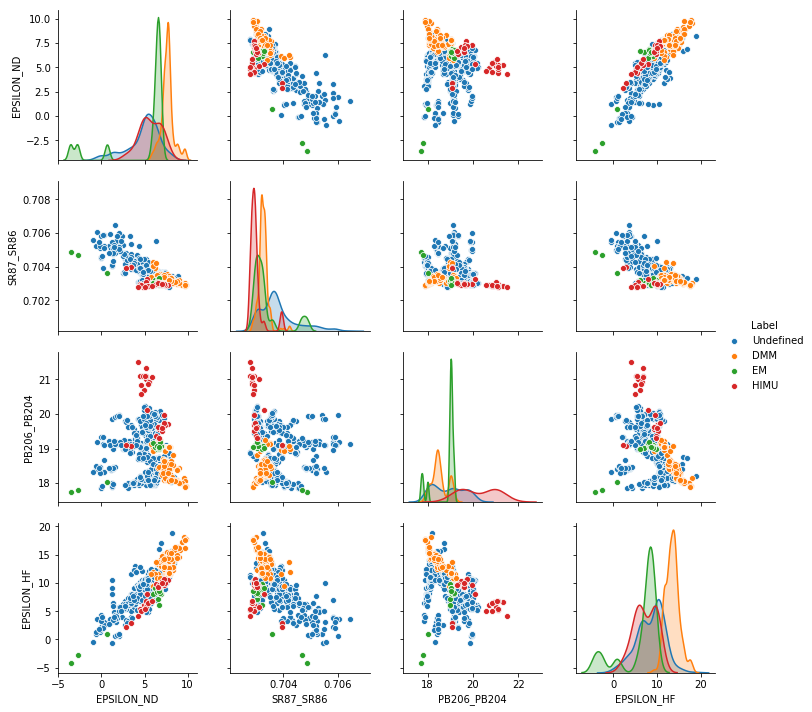

In [80]:
sns.pairplot(TrainingData,vars=['EPSILON_ND','SR87_SR86','PB206_PB204','EPSILON_HF'],hue='Label');

It's clear that not every one of these islands are in the end member compositions, but it gives us a good idea of where these compositions are. Now let's do some machine learning based on these labels.

The package we will be using is known as scikit-learn (**sklearn**)  which we will now have to import.  

In [81]:
import sklearn
from sklearn.naive_bayes import GaussianNB

 The **sklearn** package has lots of different machine learning algorithms. 
 **sklearn** algorithms have pretty similar syntax and inputs to use. The first, our $X$ values,  is an array of 'coordinates', the values of our data in the dimensions that we care about (isotopic ratios). Here we have four different ratios, so effectively we're getting an array of four dimensional coordinates, one set of coordinates for each data point.
 
 The machine learning algorithm we will be using for our mantle isotope task is known as the 'Gaussian Naive Bayesian' algorithm. This applies a normal distribution to describe the region in data space each of our labels is found in. It is ideal for us because our end-members are separated spatially.
 
 So, first we define the $X$ array.  It has as its axes each of the isotopic systems we care about ('EPSILON_ND','SR87_SR86','PB206_PB204','EPSILON_HF') columns of the data TrainingData dataframe.  

In [82]:
# define the array of 'x' values
X=np.array([TrainingData['EPSILON_ND'],TrainingData['SR87_SR86'],\
            TrainingData['PB206_PB204'],TrainingData['EPSILON_HF']])
# take the transpose so each column is an axis instead of the rows.  
X=X.transpose()
# take a peek at X:
print (X.shape)
print (X)

(597, 4)
[[ 3.41371494  0.704123   17.938       8.098025  ]
 [ 6.0081383   0.703691   18.1663     10.53804127]
 [ 7.49066593  0.702982   19.098       9.97224039]
 ...
 [ 8.42699917  0.703331   18.174      13.82675885]
 [ 7.27608956  0.702898   18.797      10.25514083]
 [ 7.82228395  0.702773   18.868      10.99775448]]


We also need a $Y$ value, which is our list of labels for each of the data points.

In [83]:
Y=TrainingData.Label.values
# take a look at the first 10:
Y[0:10]

array(['Undefined', 'Undefined', 'Undefined', 'Undefined', 'Undefined',
       'Undefined', 'DMM', 'Undefined', 'Undefined', 'Undefined'],
      dtype=object)

Now let's do the 'learning'. **GaussianNB()** is a class with a lot of methods, so the idea is that we create an instance of the **GaussianNB()** class called $model$.  Then we can use the method We will create a model  **.fit( )** to fit our model to our data.   This is sort of like the way we used **np.polyfit()** to get the coefficients of  best fit polynomial to some data and  then used **np.polyval()** to generate model $y$ values from a set of $x$ values.  Instead of a best-fit polynomial, which requires us to assume that the data are parabolic (and only works in two dimensions), here we are looking for relationships between four different dimensions.  We could do more dimensions, but that would just be showing off!    


Now we generate an instance using the module **sklearn.naive_bayes.GaussianNB()** we imported before, then use the **.fit()** method of that instance.  

In [84]:
model = GaussianNB() # instance of the GaussianNB class
model.fit(X, Y); # make the model

Ok, now we can apply our model to the  "leftover" dataset. We simply create a  new set of X data with our remaining data the same way that we did for our training data. Then we can get a new set of labels by using the method **.predict( )**

In [85]:
Xnew=np.array([RemainingData['EPSILON_ND'],RemainingData['SR87_SR86'],RemainingData['PB206_PB204'],RemainingData['EPSILON_HF']])

Xnew=Xnew.transpose()

Ynew = model.predict(Xnew)

Let's take a look at what just happened.  We can plot up our assigned labels using **sns.pairplot( )**.

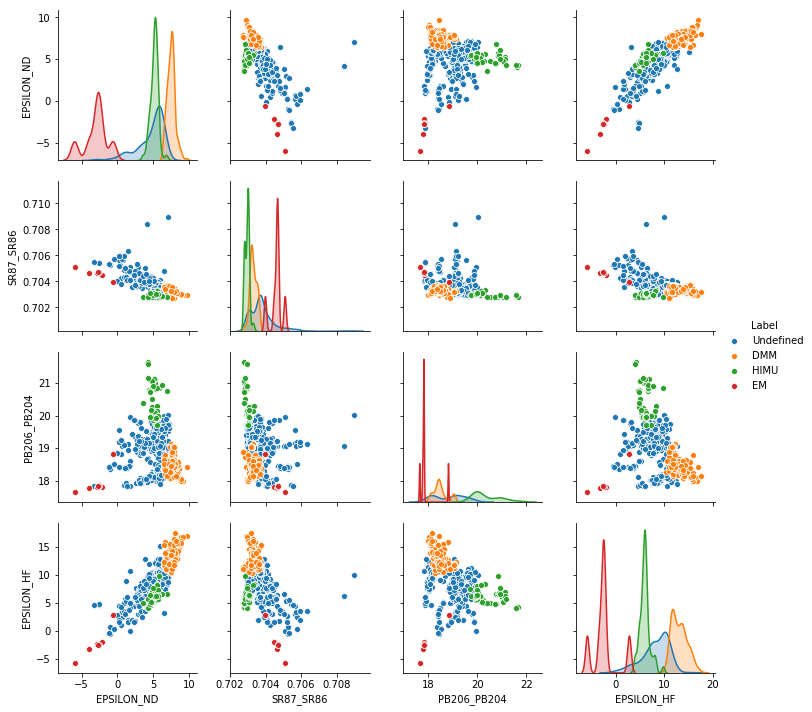

In [86]:
RemainingData['Label']=Ynew
sns.pairplot(RemainingData,vars=['EPSILON_ND','SR87_SR86','PB206_PB204','EPSILON_HF'],hue='Label');

Wow! Looks like we've got the regions right where we want them to be. This has picked out the end members  really nicely.

### Principal component analysis

You might have noticed in the pair plot that some of the projections of the data show the difference in source region better than others.  For example,  $^{206}$Pb/$^{204}$Pb vs $ \varepsilon$Nd is a lot easier to visualize than $ \varepsilon$Nd vs  $ \varepsilon$Hf. But which projection is the best one for showing differences in the data?

Principal component analysis (PCA for short) does exactly this. It's a form of unsupervised machine learning that finds a projection of the data that shows the shape of the scatter the most effectively. The dimensions it actually picks are generally very abstract and hard to relate to any 'real' measurement, but they show the scatter of the data quite nicely. In effect, instead of having to look at lots of different plots, the PCA will allow us to look at just a single two dimensional plot to see the data, instead of four.

To get labels on all our data, let's recombine our RemainingData  and TrainingData DataFrames, with the new labels.  We use the **pd.concat( )** function to do this. 

In [87]:
LabeledData=pd.concat([TrainingData,RemainingData],ignore_index=True)

Now let's import the PCA algorithm from **sklearn** and run it. The syntax is almost exactly the same as for the **GaussianNB( )** algorithm. The only difference is that we use a method called **.transform( )** to get our Y values. 

In [88]:
from sklearn.decomposition import PCA 

# set up the array
X_PCA=np.array([LabeledData['EPSILON_ND'],LabeledData['SR87_SR86'],LabeledData['PB206_PB204'],\
                        LabeledData['EPSILON_HF']])

# take the transpose
X_PCA=X_PCA.transpose()

#make an instance of the PCA class with two dimensions
pca = PCA(2)
# apply this to our X_PCA array to get the model parameters
pca.fit(X_PCA)
# get new y values using the parameters returned by pca.fit
Y_pca = pca.transform(X_PCA)

Take a look at what we have.  First, what is the shape of Y_pca? 

In [89]:
Y_pca.shape

(1194, 2)

So it is a two dimensional array.  The first axis is our first principal component and the second axis is the second.  So we can apply thes to our LabeledData dataframe.  

Now let's apply our PCA dimensions to the DataFrame:

In [90]:
LabeledData['PCA_1']=Y_pca[:,0] # first axis (axis=0)
LabeledData['PCA_2']=Y_pca[:,1] # second axis (axis=1)

**seaborn** has its own **scatterplot** function that will look more similar to the   **sns.pairplot()** function that we are already familiar with, so let's use this to plot our data.

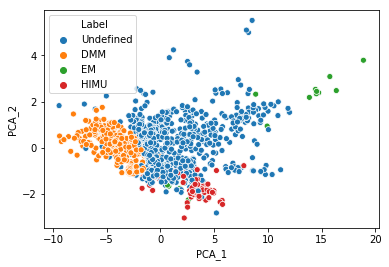

In [91]:
sns.scatterplot(x=LabeledData['PCA_1'],y=LabeledData['PCA_2'],hue=LabeledData['Label']);

This nicely shows the spread between the different mantle endmembers we see here, and shows that we potentially have some scatter towards a 4th component within the data we didn't define. This might be the 'EM2' component.

A cool (but very creepy) video demonstrating the usefulness of PCA in determining the most important dimensions of a dataset is shown below. 

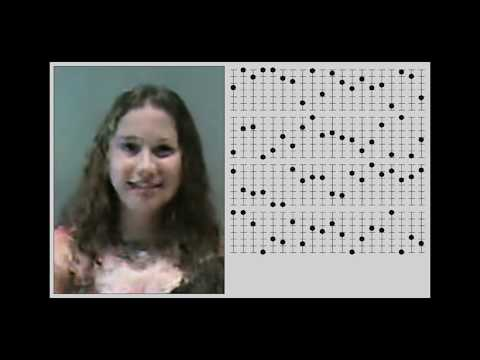

In [92]:
from IPython.display import YouTubeVideo
YouTubeVideo('4VAkrUNLKSo')

### K-mean clustering- strikes and dips

The other kind of unsupervised machine learning is known as clustering. This assigns discrete labels to data the  need to train the algorithm in any way. To get an idea of what this does, let's get some (made up) data of poles to planes similar to what we looked at in Lecture 20.

In [93]:
dirs=np.loadtxt('Datasets/Dirs.txt')
print (dirs)

[[235.38736674 227.42078113 229.11169489 ... 110.40348683 110.69690735
  108.54446744]
 [ 46.46783741  52.81490089  44.16316582 ...   6.55231966   6.87783496
    9.16472586]]


It looks like **dirs** is a 2D array with the first row being the pole azimuths (direction of the pole relative to north) and the second row being the pole plunges (angle of the pole from the horizontal).  

Let's plot this up as an equal angle plot. To save time, here are the functions we'll need for this. Note that the plot_equal_angle function is slightly different from our code in Lecture 20. It uses **plt.scatter** instead of **plt.plot( )**  to allow us to plot colors according to our labels later.

In [94]:
# Here's the equal angle function
EqualAngle = lambda Pl: 90.*np.tan(np.radians(90.-Pl)/(2.))

def plot_equal_angle(data,colors='black'):
    """
    Plots an Equal Angle plot for data d, colors are a string or list of colors
    to be passed to the points in data
    Note that this is different to the code in lecture 20 because it uses a
    scatter plot.
    """
    Azs=data[0]# array of azimuths
    Pls=data[1] # array of corresponding plunges
    fig = plt.subplot(111, polar=True) 
    # set the coordinates (like for rose diagrams)
    fig.set_theta_direction(-1) # Reverse direction of degrees (CW)
    fig.set_theta_zero_location("N") # Specify 0-degrees as North
    # for this we want the full 90 degrees, so set the scale
    plt.polar([0],[90]) ## to scale grid
    # plot the first direction as a red dot
    fig.scatter(np.radians(Azs),(EqualAngle(Pls)),c=colors)
    # plot the second direction as a blue square

    # make a list of contours to plot
    # notice use of list comprehension
    # label the azimuths at 20 degree intervals
    AzContours=range(0,360,20)
    AzLabels=[str(p) for p in AzContours]
    plt.thetagrids(AzContours,AzLabels)

    # and now the plunges
    PlContours=[EqualAngle(a) for a in range(10,90,20)] ##don't include center or edge
    # make a list of labels
    PlLabels=[str(a) for a in range(10,90,20)]
    # draw on the plunge contours and label them
    plt.rgrids(PlContours,PlLabels)
    # label the plot
    plt.title('Equal Angle Net');

Now let's plot up our data up as black circles

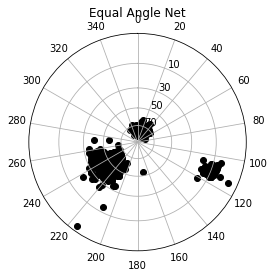

In [50]:
plot_equal_angle(dirs,'black')

Interesting. There appear to be three main groups of bedding pole directions represented in this dataset. We could categorize these using machine learning using a supervised method, like the **GaussianNB( )** algorithm.  But why not do something much faster and easier. 

There is an 'unsupervised' approach called the k-mean clustering algorithm and there is a module for that in the **sklearn.cluster** package called **KMeans**.  This algorithm will automatically categorize the different 'clusters' in this dataset. Let's try it out. The syntax for predicting clusters is identical to our **GaussianNB( )** method. 

First, we import the module: 

In [51]:
from sklearn.cluster import KMeans

Now we can try it out.  

In [53]:
# make the X array, but 
# transposed so the azimuths and plunges are columns, instead of rows. 
X_kmeans=dirs.transpose() 
# make an instance of the KMeans class with 3 clusters
kmeans = KMeans(n_clusters=3)
#Apply the model to the data
kmeans.fit(X_kmeans)
# Then get the Y_means predictions
Y_kmeans = kmeans.predict(X_kmeans)

Now let's plot up the data, using our new 'Y_kmeans' values as the colors.

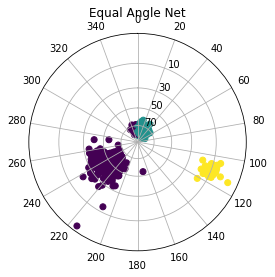

In [54]:
plot_equal_angle(dirs,colors=Y_kmeans)

Uh oh! The algorithm seems to have got it partially wrong. Some of the data that are clearly in one cluster seems to have been categorized as part of another. 

This is because of the polar coordinate system we are using. The data that have been incorrectly labelled have pole azimuths ranging from 320-360 degrees. Because the numbers 320-360 are much closer to the pole azimuths of our other cluster (170-280 ish), the algorithm  clusters them together with the purple group. Let's plot up what the algorithm is actually 'seeing'.

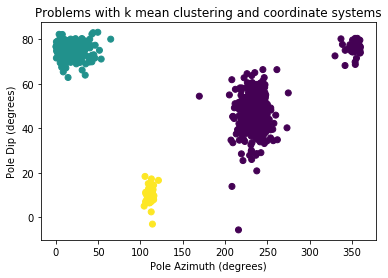

In [56]:
plt.scatter(dirs[0],dirs[1],c=Y_kmeans)
plt.xlabel('Pole Azimuth (degrees)')
plt.ylabel('Pole Dip (degrees)')
plt.title('Problems with k mean clustering and coordinate systems');


An easy way to fix this is to convert our data to cartesian coordinates instead of polar coordinates. Let's use our trusty **dir2cart** function to convert from polar (azimuth and plunge) to cartesian coordinates (x,y,z).

In [57]:
def dir2cart(Dir):
    """
    converts polar directions to cartesian coordinates
    Inputs: 
        Dir[Azimuth,Plunge]:  directions in degreess
    Output:
        [X,Y,Z]: cartesian coordinates
    """
    Az,Pl=np.radians(Dir[0]),np.radians(Dir[1])
    return [np.cos(Az)*np.cos(Pl),np.sin(Az)*np.cos(Pl),np.sin(Pl)]

In [59]:
carts=dir2cart(dirs)

In [60]:
print (carts)

[array([-0.39123399, -0.40893699, -0.4695733 , ..., -0.34635187,
       -0.35088102, -0.31398061]), array([-0.56685851, -0.4450395 , -0.54231388, ...,  0.93113865,
        0.92873128,  0.93597444]), array([0.72498785, 0.79668713, 0.69670407, ..., 0.11411045, 0.11975278,
       0.15927343])]


The documentation of **dir2carts( )**  says that it returns a  a list of x,y,z coordinates.  Looking at what is returned, we see that it is a list of arrays. The first element is an array of x values, the second, y and the third is z.  

What we want is to make carts an array and transpose it so that the columns are x,y,z instead of the rows.   Let's assign the transposed array to our friend $X_kmeans$. And then repeat the treatment.

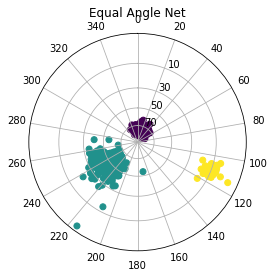

In [65]:
# make cart into an array:
carts=np.array(carts)
# and transpose it.  
X_kmeans=carts.transpose()
# make an instance of the KMeans class with 3 clusters.  
kmeans = KMeans(n_clusters=3)
# stuff X_kmeans into the kmeans fit method
kmeans.fit(X_kmeans)
# take the results and put into our prediction method
Y_kmeans = kmeans.predict(X_kmeans)

# and plot them up!
plot_equal_angle(dirs,colors=Y_kmeans)

This looks a lot better. 

One thing you might be wondering about is that we told the algorithm to find three clusters.  This made sense after we looked at the data in the equal angle projection.  But it could be arbitrary!  What if we didn't specify the number of clusters that we want. What happens then?  

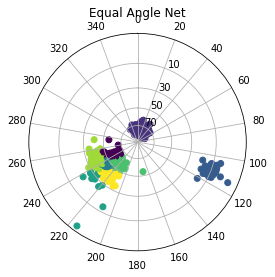

In [69]:
kmeans = KMeans()
kmeans.fit(X_kmeans)
Y_kmeans = kmeans.predict(X_kmeans)
plot_equal_angle(dirs,colors=Y_kmeans)

Unfortunately this doesn't work very well. This is because the algorithm looks for clusters that are the same size. As one of our clusters is a lot bigger than the other two, the algorithm breaks it up into pieces.  Take home message:  Try to look at your data and make intellegent decisions about things like the number of clusters, etc.  

### Regression

You may have noticed that the second kind of supervised learning, regression, hasn't been covered here. This is because many of the problems solved by regression are of the line and curve fitting type. We covered line and curve fitting in Lecture 16, but **scikit-learn** has some more advanced regression techniques that might do a better job with your data. To learn more about this application of **scikit-learn**, go to https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html

### A word of warning

Machine learning models are great, but you should always question how well they did their job. For our examples we chose in this class, we can see visually that the algorithm did pretty well (except when they didn't). However, in some cases your choice of algorithm could be poor for the problem you are trying to solve. **scikit-learn** has multiple different algorithms to solve similar kinds of problems. For example with clustering we have:

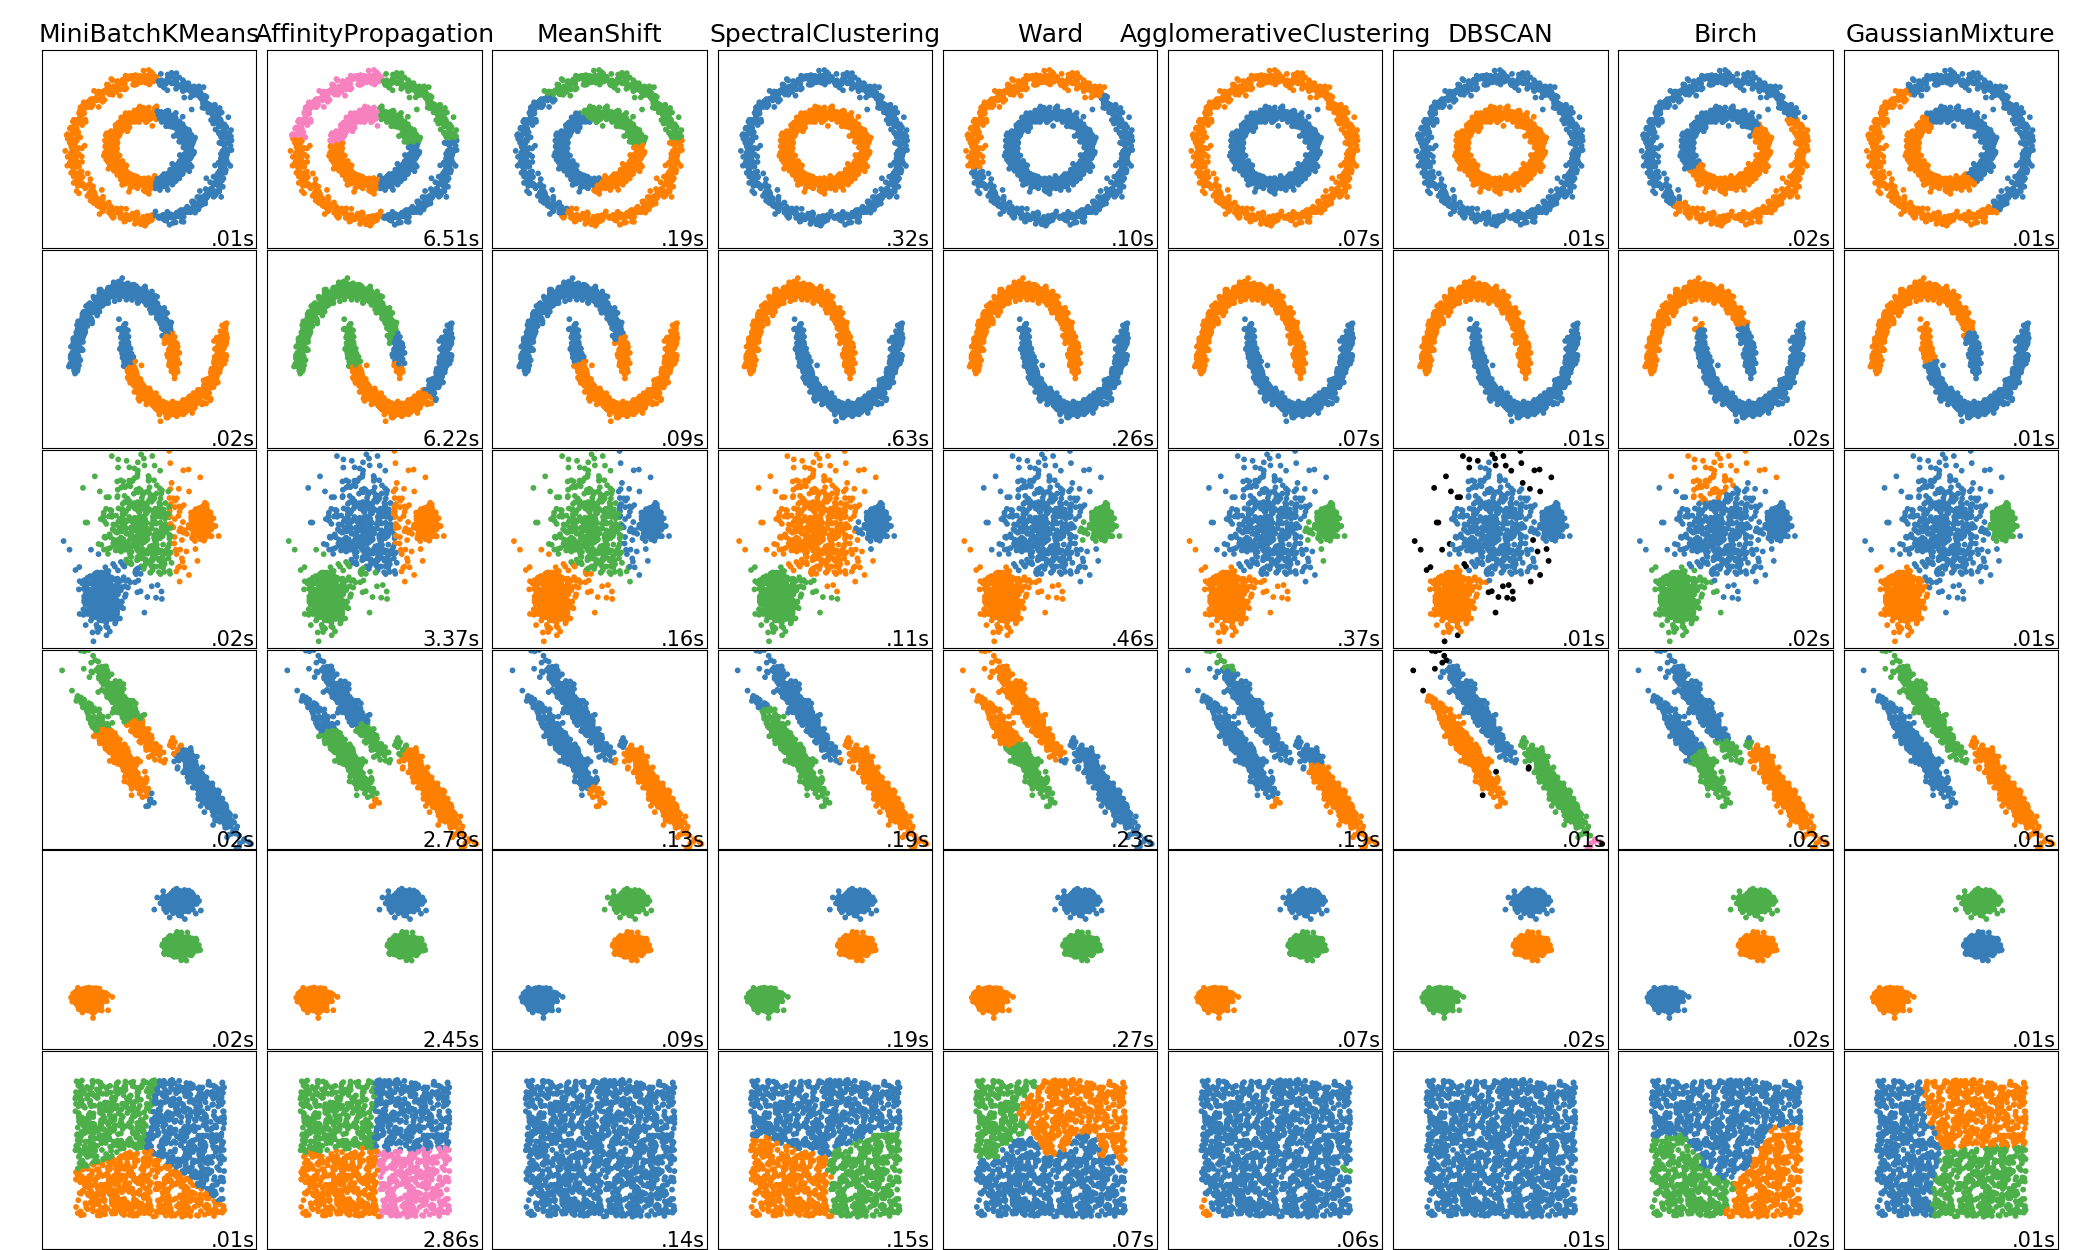

In [70]:
Image(filename='Figures/Clustering types.png')

Image from https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

It's clear from this that you can't just use an algorithm and trust that your answer is 'right'. You need some way of verifying it.

To do this, **scikit-learn** has an implemented method known as _cross validation_. To learn more about cross validation- have a read at https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html